# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

33.577736632188738

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

20.147741307512522

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

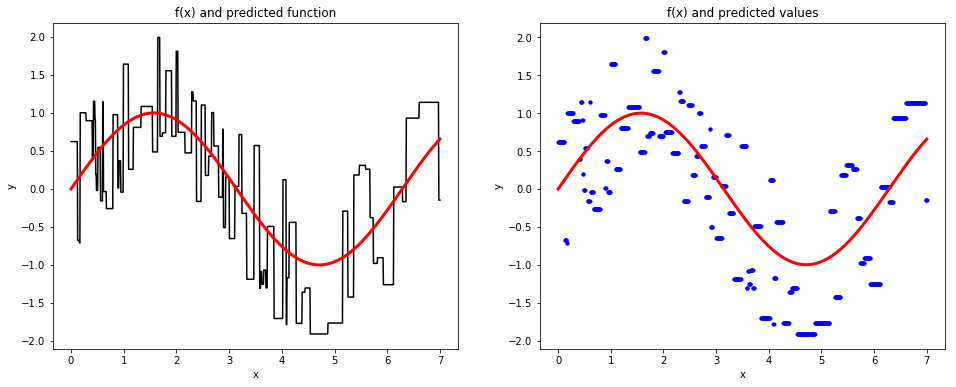

In [5]:
np.random.seed(25)
x = np.random.exponential(5, sample_size)
y = f(x) + np.random.uniform(-1, 1, sample_size)

tree = DecisionTreeRegressor()
tree.fit(x.reshape(-1, 1), y)
prediction = tree.predict(linspace.reshape(-1, 1))

plt.figure(1, figsize=[16, 6])

plt.subplot(1, 2, 1)
plt.title('f(x) and predicted function')
plt.plot(linspace, prediction, color='black')
plt.plot(linspace, f(linspace), color='red', lw=3)
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 2, 2)
plt.title('f(x) and predicted values')
plt.scatter(linspace, prediction, color='blue', marker='.')
plt.plot(linspace, f(linspace), color='red', lw=3)
plt.xlabel('x')
plt.ylabel('y')

    
plt.show()

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

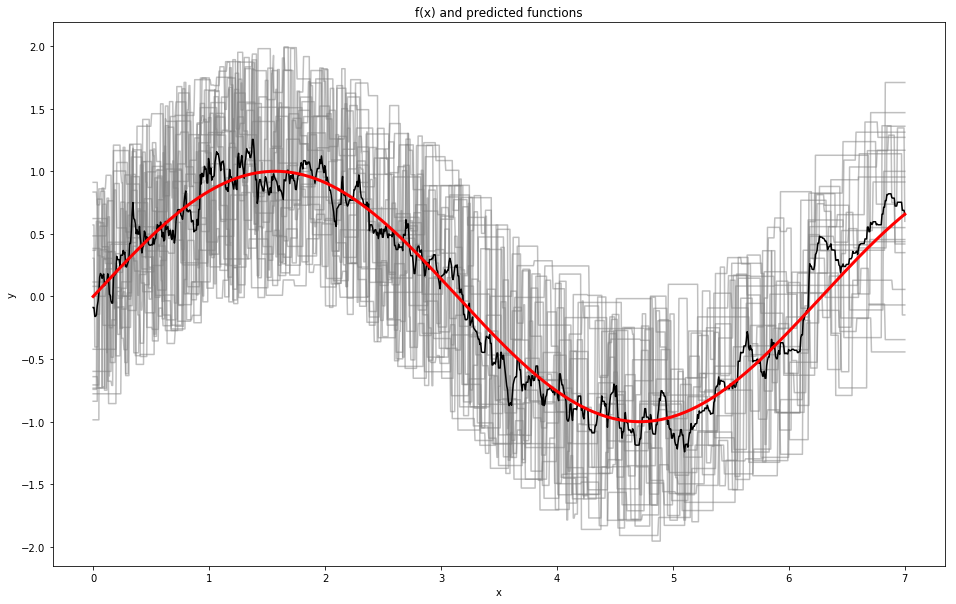

In [6]:
np.random.seed(25)

all_predictions = np.zeros((1000,))

plt.figure(1, figsize=[16, 10])

plt.title('f(x) and predicted functions')
plt.xlabel('x')
plt.ylabel('y')

for i in range(samples_num):  
    x = np.random.exponential(5, sample_size)
    y = f(x) + np.random.uniform(-1, 1, sample_size)

    tree = DecisionTreeRegressor()
    tree.fit(x.reshape(-1, 1), y)
    prediction = tree.predict(linspace.reshape(-1, 1))
    all_predictions += prediction
    
    plt.plot(linspace, prediction, color='gray', alpha=0.5)
    
    
plt.plot(linspace, all_predictions/samples_num, color='black')
plt.plot(linspace, f(linspace), color='red', lw=3)
plt.show()

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

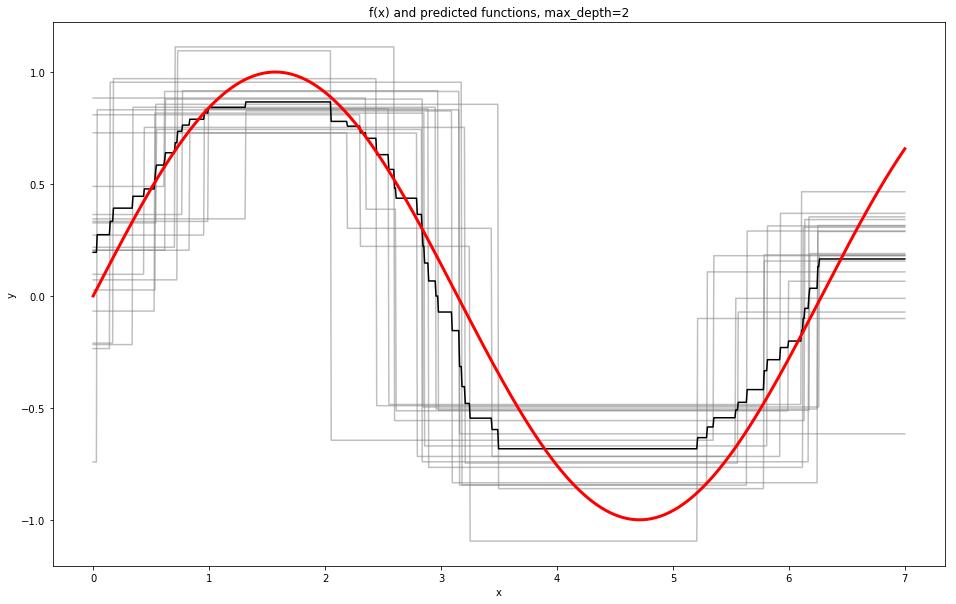

In [7]:
np.random.seed(25)

all_predictions = np.zeros((1000,))

plt.figure(1, figsize=[16, 10])

plt.title('f(x) and predicted functions, max_depth=2')
plt.xlabel('x')
plt.ylabel('y')

for i in range(samples_num):  
    x = np.random.exponential(5, sample_size)
    y = f(x) + np.random.uniform(-1, 1, sample_size)

    tree = DecisionTreeRegressor(max_depth=2)
    tree.fit(x.reshape(-1, 1), y)
    prediction = tree.predict(linspace.reshape(-1, 1))
    all_predictions += prediction
    
    plt.plot(linspace, prediction, color='gray', alpha=0.5)
    
    
plt.plot(linspace, all_predictions/samples_num, color='black')
plt.plot(linspace, f(linspace), color='red', lw=3)
plt.show()

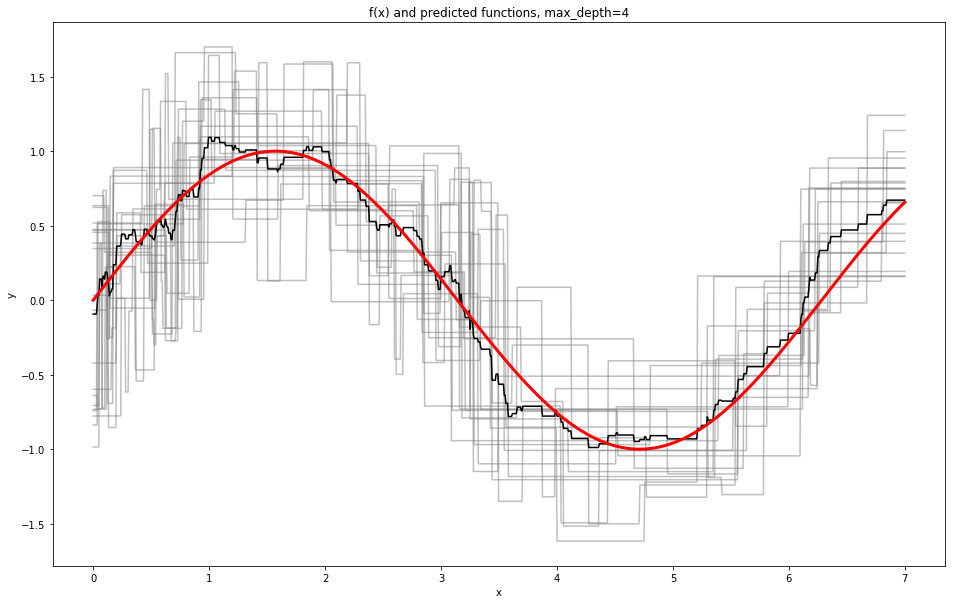

In [8]:
np.random.seed(25)

all_predictions = np.zeros((1000,))

plt.figure(1, figsize=[16, 10])

plt.title('f(x) and predicted functions, max_depth=4')
plt.xlabel('x')
plt.ylabel('y')

for i in range(samples_num):  
    x = np.random.exponential(5, sample_size)
    y = f(x) + np.random.uniform(-1, 1, sample_size)

    tree = DecisionTreeRegressor(max_depth=4)
    tree.fit(x.reshape(-1, 1), y)
    prediction = tree.predict(linspace.reshape(-1, 1))
    all_predictions += prediction
    
    plt.plot(linspace, prediction, color='gray', alpha=0.5)
    
    
plt.plot(linspace, all_predictions/samples_num, color='black')
plt.plot(linspace, f(linspace), color='red', lw=3)
plt.show()

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

Поскольку решающее дерево не умеет предсказывать гладкую функцию, смещение всегда есть.

Смещение минимально при отсутсвии ограничения на глубину, так как это наиболее сложный алгоритм, способный лучше всего приблизиться к идеальному (хотя уже при max_depth=4 смещение очень низкое).

__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

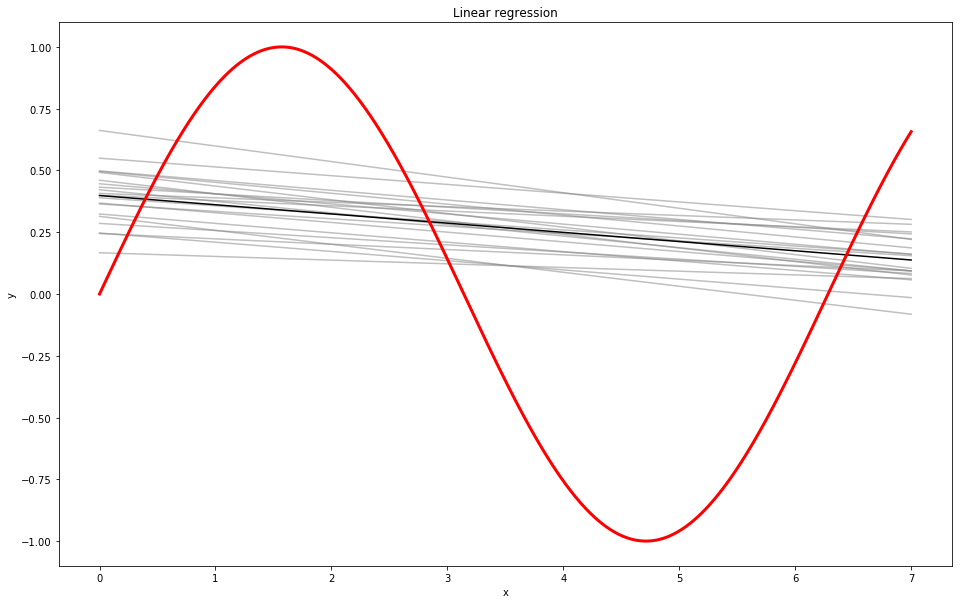

In [9]:
np.random.seed(25)

all_predictions = np.zeros((1000,))

plt.figure(1, figsize=[16, 10])

plt.title('Linear regression')
plt.xlabel('x')
plt.ylabel('y')

for i in range(samples_num):  
    x = np.random.exponential(5, sample_size)
    y = f(x) + np.random.uniform(-1, 1, sample_size)

    linreg = LinearRegression()
    linreg.fit(x.reshape(-1, 1), y)
    prediction = linreg.predict(linspace.reshape(-1, 1))
    all_predictions += prediction
    
    plt.plot(linspace, prediction, color='gray', alpha=0.5)
    
    
plt.plot(linspace, all_predictions/samples_num, color='black')
plt.plot(linspace, f(linspace), color='red', lw=3)
plt.show()

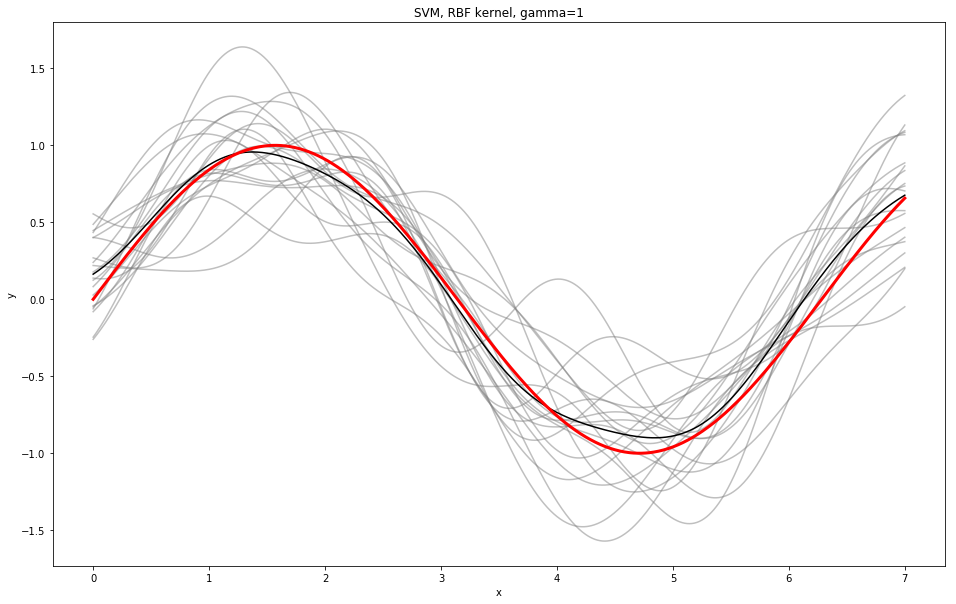

In [10]:
np.random.seed(25)

all_predictions = np.zeros((1000,))

plt.figure(1, figsize=[16, 10])

plt.title('SVM, RBF kernel, gamma=1')
plt.xlabel('x')
plt.ylabel('y')

for i in range(samples_num):  
    x = np.random.exponential(5, sample_size)
    y = f(x) + np.random.uniform(-1, 1, sample_size)

    svm = SVR(kernel='rbf', gamma=1)
    svm.fit(x.reshape(-1, 1), y)
    prediction = svm.predict(linspace.reshape(-1, 1))
    all_predictions += prediction
    
    plt.plot(linspace, prediction, color='gray', alpha=0.5)
    
    
plt.plot(linspace, all_predictions/samples_num, color='black')
plt.plot(linspace, f(linspace), color='red', lw=3)
plt.show()

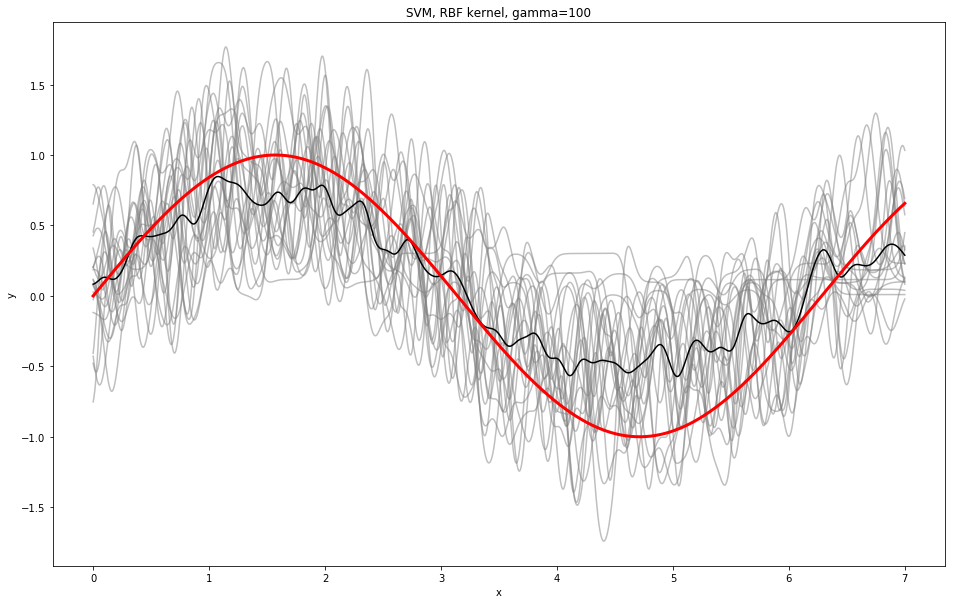

In [11]:
np.random.seed(25)

all_predictions = np.zeros((1000,))

plt.figure(1, figsize=[16, 10])

plt.title('SVM, RBF kernel, gamma=100')
plt.xlabel('x')
plt.ylabel('y')

for i in range(samples_num):  
    x = np.random.exponential(5, sample_size)
    y = f(x) + np.random.uniform(-1, 1, sample_size)

    svm = SVR(kernel='rbf', gamma=100)
    svm.fit(x.reshape(-1, 1), y)
    prediction = svm.predict(linspace.reshape(-1, 1))
    all_predictions += prediction
    
    plt.plot(linspace, prediction, color='gray', alpha=0.5)
    
    
plt.plot(linspace, all_predictions/samples_num, color='black')
plt.plot(linspace, f(linspace), color='red', lw=3)
plt.show()

Линейная регрессия совершенно не подходит для таких данных, огромное смещение.

SVM с гауссовским ядром и $\gamma = 1$ позволяет добиться низкого смещения и выучить зависимость, очень близкую к реальной.

SVM с гауссовским ядром и $\gamma = 100$ переобучается, что приводит к увеличению смещения по сравнению с $\gamma = 1$.

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [12]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [13]:
mushrooms = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', header=None)
tic_tac_toe = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data', header=None)
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header=None)
nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', header=None)

In [14]:
cars[6].value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: 6, dtype: int64

In [15]:
nursery[8].value_counts()

not_recom     4320
priority      4266
spec_prior    4044
very_recom     328
recommend        2
Name: 8, dtype: int64

In [16]:
# изменение классов для cars и nursery
cars[6] = cars[6].replace(to_replace=['unacc', 'vgood'], value=['acc', 'good'])
nursery[8] = nursery[8].replace(to_replace=['recommend', 'very_recom', 'spec_prior'], value=['not_recom', 'priority', 'priority'])

In [17]:
cars[6].value_counts()

acc     1594
good     134
Name: 6, dtype: int64

In [18]:
nursery[8].value_counts()

priority     8638
not_recom    4322
Name: 8, dtype: int64

Все признаки во всех датасетах категориальные, однако в датасетах cars и nursery значения признаков являются упорядоченными.

In [19]:
# кодирование категориальных (то есть всех) признаков с помощью LabelEncoder
for i in range(len(mushrooms.columns)):
    mushrooms[i] = LabelEncoder().fit_transform(mushrooms[i])
for i in range(len(tic_tac_toe.columns)):
    tic_tac_toe[i] = LabelEncoder().fit_transform(tic_tac_toe[i])
for i in range(len(cars.columns)):
    cars[i] = LabelEncoder().fit_transform(cars[i])
for i in range(len(nursery.columns)):
    nursery[i] = LabelEncoder().fit_transform(nursery[i])

In [20]:
# Создадим две матрицы признаковых описаний для каждого датасета. В одной оставим закодированные с помощью 
# LabelEncoder признаки, тогда они будут считаться вещественными, а в другой для каждого возможного значения 
# признака создадим дамми, чтобы признаки считались категориальными.

mushrooms_y = np.array(mushrooms[0])
mushrooms_x = np.array(mushrooms[list(range(1, len(mushrooms.columns)))])
mushrooms_x_categorical = np.array(pd.get_dummies(mushrooms.drop([0], axis=1), \
                                                  columns=list(range(1, len(mushrooms.columns))), dummy_na=True))

tic_tac_toe_y = np.array(tic_tac_toe[9])
tic_tac_toe_x = np.array(tic_tac_toe[list(range(9))])
tic_tac_toe_x_categorical = np.array(pd.get_dummies(tic_tac_toe.drop([9], axis=1), columns=list(range(9)), dummy_na=True))

cars_y = np.array(cars[6])
cars_x = np.array(cars[list(range(6))])
cars_x_categorical = np.array(pd.get_dummies(cars.drop([6], axis=1), columns=list(range(6)), dummy_na=True))

nursery_y = np.array(nursery[8])
nursery_x = np.array(nursery[list(range(8))])
nursery_x_categorical = np.array(pd.get_dummies(nursery.drop([8], axis=1), columns=list(range(8)), dummy_na=True))


Поскольку все признаки являются категориальными, вторая и третья модель совпадают.

Проведем сравнение результатов двух моделей: с вещественными признаками и с категориальными (корректными) признаками.

In [21]:
np.random.seed(25)
print('mushrooms scores:')
scores = list(cross_val_score(DecisionTreeClassifier(), mushrooms_x, mushrooms_y, cv=10, scoring='accuracy'))
print('real:', scores, 'mean =', np.mean(scores))
scores = list(cross_val_score(DecisionTreeClassifier(), mushrooms_x_categorical, mushrooms_y, cv=10, scoring='accuracy'))
print('categorical:', scores, 'mean =', np.mean(scores))
print()
print('tic_tac_toe scores:')
scores = list(cross_val_score(DecisionTreeClassifier(), tic_tac_toe_x, tic_tac_toe_y, cv=10, scoring='accuracy'))
print('real:', scores, 'mean =', np.mean(scores))
scores = list(cross_val_score(DecisionTreeClassifier(), tic_tac_toe_x_categorical, tic_tac_toe_y, cv=10, scoring='accuracy'))
print('categorical:', scores, 'mean =', np.mean(scores))
print()
print('cars scores:')
scores = list(cross_val_score(DecisionTreeClassifier(), cars_x, cars_y, cv=10, scoring='accuracy'))
print('real:', scores, 'mean =', np.mean(scores))
scores = list(cross_val_score(DecisionTreeClassifier(), cars_x_categorical, cars_y, cv=10, scoring='accuracy'))
print('categorical:', scores, 'mean =', np.mean(scores))
print()
print('nursery scores:')
scores = list(cross_val_score(DecisionTreeClassifier(), nursery_x, nursery_y, cv=10, scoring='accuracy'))
print('real:', scores, 'mean =', np.mean(scores))
scores = list(cross_val_score(DecisionTreeClassifier(), nursery_x_categorical, nursery_y, cv=10, scoring='accuracy'))
print('categorical:', scores, 'mean =', np.mean(scores))
print()

mushrooms scores:
real: [0.68511685116851173, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.89642416769420463, 1.0] mean = 0.958154101886
categorical: [0.68511685116851173, 1.0, 1.0, 1.0, 0.99753997539975403, 1.0, 1.0, 1.0, 1.0, 1.0] mean = 0.968265682657

tic_tac_toe scores:
real: [0.7010309278350515, 0.73195876288659789, 0.51041666666666663, 0.82291666666666663, 0.54166666666666663, 0.70833333333333337, 0.84210526315789469, 0.84210526315789469, 0.9263157894736842, 0.89473684210526316] mean = 0.752158618195
categorical: [0.73195876288659789, 0.87628865979381443, 0.42708333333333331, 0.94791666666666663, 0.86458333333333337, 0.77083333333333337, 0.96842105263157896, 0.76842105263157889, 0.95789473684210524, 0.88421052631578945] mean = 0.819761145777

cars scores:
real: [0.91954022988505746, 0.94827586206896552, 0.92528735632183912, 0.97126436781609193, 0.97093023255813948, 0.98837209302325579, 0.91860465116279066, 0.87790697674418605, 0.93023255813953487, 0.95348837209302328] mean = 0.940390269

__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

Алгоритм с категориальными признаками работает лучше для всех датасетов, кроме cars, что логично, потому что признаки в действительности являются категориальными и именно такое их кодирование должно в общем случае давать лучший результат. Однако в датасете cars на значениях любого признака существует отношение порядка (vhigh > high > med > low и т. п.), и деревьям может быть проще выучить его, когджа признаки закодированы вещественными числами, поэтому для cars результат первого алгоритма лучше.

По умолчанию при разбиении листа алгоритм рассматривает случайную подвыборку признаков и ищет лучшее разбиение по ней. Поэтому можно улучшить работиу алгоритма с помощью отбора признаков.

### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [31]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [32]:
wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [33]:
wine_y = np.array(wine['quality'])
wine_x = np.array(wine.drop('quality', axis=1))

In [34]:
np.random.seed(25)

tree_scores = list(cross_val_score(DecisionTreeClassifier(), wine_x, wine_y, cv=3, scoring='accuracy'))
bagging_scores1 = list(cross_val_score(BaggingClassifier(n_estimators=100), wine_x, wine_y, cv=3, scoring='accuracy'))
bagging_scores2 = list(cross_val_score(BaggingClassifier(n_estimators=100, max_features=0.5), wine_x, wine_y, cv=3, scoring='accuracy'))
forest_scores = list(cross_val_score(RandomForestClassifier(n_estimators=100), wine_x, wine_y, cv=3, scoring='accuracy'))

In [26]:
print('DecisionTree: mean_score =', np.mean(tree_scores), 'all_scores:', tree_scores)
print()
print('BaggingClassifier: mean_score =', np.mean(bagging_scores1), 'all_scores:', bagging_scores1)
print()
print('BaggingClassifier with random subspaces: mean_score =', np.mean(bagging_scores2), 'all_scores:', bagging_scores2)
print()
print('RandomForest: mean_score =', np.mean(forest_scores), 'all_scores:', forest_scores)

DecisionTree: mean_score = 0.457769442755 all_scores: [0.48037383177570092, 0.42589118198874298, 0.46704331450094161]

BaggingClassifier: mean_score = 0.55355817047 all_scores: [0.51028037383177571, 0.57035647279549717, 0.58003766478342744]

BaggingClassifier with random subspaces: mean_score = 0.542305793031 all_scores: [0.50467289719626163, 0.54409005628517826, 0.57815442561205277]

RandomForest: mean_score = 0.56606616397 all_scores: [0.52897196261682244, 0.57035647279549717, 0.59887005649717517]


Получились почти те результаты, которые ожидались, за исключением того, что BaggingClassifier с использованием случайных подпространств оказался чуть хуже, чем обычный BaggingClassifier.

#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [36]:
x_train, x_test, y_train, y_test = train_test_split(wine_x, wine_y, train_size = 0.7, test_size = 0.3, random_state = 25)

In [45]:
np.random.seed(25)

scores = []
forest = RandomForestClassifier(n_estimators=100, warm_start=True)
forest.fit(x_train, y_train)
scores.append(accuracy_score(y_test, forest.predict(x_test)))

for n in range(200, 5001, 100):
    forest.set_params(n_estimators=n)
    forest.fit(x_train, y_train)
    scores.append(accuracy_score(y_test, forest.predict(x_test)))

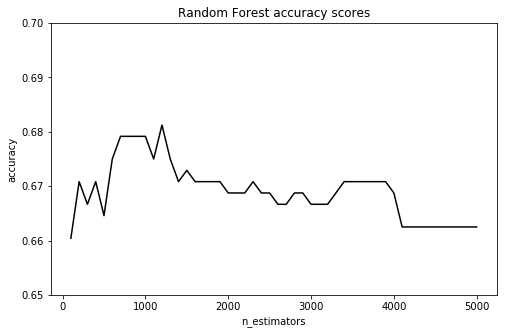

In [46]:
plt.figure(1, figsize=[8, 5])

plt.title('Random Forest accuracy scores')
plt.plot(range(100, 5001, 100), scores, color='black')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.ylim([0.65, 0.7])

plt.show()

In [47]:
list(range(100, 5001, 100))[np.argmax(scores)]

1200

Наилучшее качество получено при использовании 1200 деревьев. Дальнейшее увеличение количества деревьев приводит к падению качества, что может быть связано с переобучением.

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

In [48]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


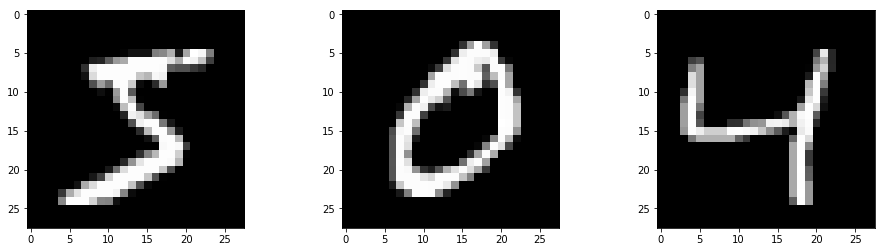

In [49]:
clr_map = plt.get_cmap('gray')

plt.figure(1, figsize=[16, 4])

plt.subplot(1, 3, 1)
plt.imshow(x_train[0], cmap=clr_map)

plt.subplot(1, 3, 2)
plt.imshow(x_train[1], cmap=clr_map)

plt.subplot(1, 3, 3)
plt.imshow(x_train[2], cmap=clr_map)

plt.show()

Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

In [50]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

In [51]:
n_classes = 10
n_pixels = 28

# recast inputs to [0, 1]
x_train = x_train / 255
x_test = x_test / 255

# one-hot encoding for classes
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [52]:
model = Sequential()
model.add(Flatten(input_shape=(n_pixels, n_pixels)))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
np.random.seed(25)
model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
 - 3s - loss: 0.2429 - acc: 0.9295
Epoch 2/10
 - 3s - loss: 0.1029 - acc: 0.9679
Epoch 3/10
 - 3s - loss: 0.0717 - acc: 0.9774
Epoch 4/10
 - 3s - loss: 0.0544 - acc: 0.9826
Epoch 5/10
 - 4s - loss: 0.0435 - acc: 0.9858
Epoch 6/10
 - 4s - loss: 0.0349 - acc: 0.9887
Epoch 7/10
 - 3s - loss: 0.0298 - acc: 0.9905
Epoch 8/10
 - 3s - loss: 0.0259 - acc: 0.9915
Epoch 9/10
 - 3s - loss: 0.0226 - acc: 0.9926
Epoch 10/10
 - 3s - loss: 0.0207 - acc: 0.9933


In [55]:
print('accuracy =', model.evaluate(x_test, y_test, verbose=0)[1])

accuracy = 0.9788


__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

In [56]:
x_train = x_train.reshape(x_train.shape[0], n_pixels, n_pixels, 1)
x_test = x_test.reshape(x_test.shape[0], n_pixels, n_pixels, 1)

In [57]:
model = Sequential()
model.add(Conv2D(32, (6, 6), input_shape=(n_pixels, n_pixels, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
np.random.seed(25)
model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
 - 31s - loss: 0.1642 - acc: 0.9495
Epoch 2/10
 - 30s - loss: 0.0548 - acc: 0.9829
Epoch 3/10
 - 31s - loss: 0.0405 - acc: 0.9874
Epoch 4/10
 - 31s - loss: 0.0329 - acc: 0.9894
Epoch 5/10
 - 31s - loss: 0.0265 - acc: 0.9917
Epoch 6/10
 - 32s - loss: 0.0221 - acc: 0.9929
Epoch 7/10
 - 31s - loss: 0.0195 - acc: 0.9937
Epoch 8/10
 - 30s - loss: 0.0163 - acc: 0.9949
Epoch 9/10
 - 29s - loss: 0.0158 - acc: 0.9950
Epoch 10/10
 - 29s - loss: 0.0126 - acc: 0.9963


In [59]:
print('accuracy =', model.evaluate(x_test, y_test, verbose=0)[1])

accuracy = 0.9916


__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 

In [62]:
model = Sequential()
model.add(Conv2D(32, (6, 6), input_shape=(n_pixels, n_pixels, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(16, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
np.random.seed(25)
model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
 - 35s - loss: 0.2176 - acc: 0.9311
Epoch 2/10
 - 32s - loss: 0.0762 - acc: 0.9761
Epoch 3/10
 - 32s - loss: 0.0568 - acc: 0.9821
Epoch 4/10
 - 32s - loss: 0.0509 - acc: 0.9839
Epoch 5/10
 - 32s - loss: 0.0433 - acc: 0.9863
Epoch 6/10
 - 32s - loss: 0.0422 - acc: 0.9871
Epoch 7/10
 - 32s - loss: 0.0377 - acc: 0.9883
Epoch 8/10
 - 32s - loss: 0.0336 - acc: 0.9890
Epoch 9/10
 - 32s - loss: 0.0336 - acc: 0.9893
Epoch 10/10
 - 32s - loss: 0.0297 - acc: 0.9904


In [64]:
print('accuracy =', model.evaluate(x_test, y_test, verbose=0)[1])

accuracy = 0.9923


При добавлении двух dropout слоев во время обучения на всех эпохах получено более низкое качетсво, однако на тестовой выборке качество немного увеличилось. Это связано с тем, что dropout препятствует переобучению.